### Experiment : Explore SHAP and LIME for model interpretibility of RNN model
### Objectives

1. Train RNN model with Fasttext embedding
2. Use SHAP for interpretibility
3. Use LIME for interpretibility
4. Get to conclusion by reading misclassified texts

### Observations

1. 
2. 
3. 

### Solutions and further investigation

1. 
2. 
3. 

### Load Modeules and datasets

In [2]:
from __future__ import unicode_literals
# set matplotlib font to visualize sinhala font in plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

path = 'C:/Users/Kavishka/anaconda3/Library/share/fonts/Nirmala.ttf'
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow.keras.backend as K
#from keras import layers
from sklearn import metrics
#from keras import regularizers
#from keras import models,optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.layers import Dense,Input,SpatialDropout1D,Dropout,Flatten, SimpleRNN,LSTM,RNN,GRU
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import gensim
pd.set_option('display.max_colwidth', 1000)
# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills
import sinhala_stemmer

In [27]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
from neptunecontrib.api import log_table,log_chart
from neptunecontrib.monitoring.keras import NeptuneMonitor
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
     # log_text("Model_summary",summary)   log_image()  
     # #callbacks=[NeptuneMonitor()])   

Project(codekcg23/Research-Experiments)

In [5]:
# load datasets - no preprocessing
path = '../Datasets/processed/no_stemming/'
df_A = pd.read_csv(path+'df_A.csv')     

In [6]:
# remove NaN entries in dataset
df_A.drop(index =[610,30a70],inplace=True)

### Embedding

In [10]:
def load_emb_model(emb_model):
    from gensim.models import word2vec
    import gensim.models as FastText
    from gensim.test.utils import datapath
    
    if emb_model == "w2v_skipgram":
        model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/word2vec/word2vec_300.w2v")
    elif emb_model == "w2v_cbow":
        model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/CBOW-word2vec/cbow_300.w2v")
    elif emb_model == "fasttext":
        #FastText.load_fasttext_format("../../../corpus/analyzed/saved_models/wiki.si.bin")
        model = FastText.fasttext.load_facebook_model(datapath("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/cc.si.300.bin"))
        #model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/fasttext_300.w2v")
    else:
        print("Invalid argument. Need w2v_skipgram or w2v_cbow or fasttext as argument")
        model = None
    return model

def get_emb_index(model):
    from gensim.models import word2vec
    embeddings_index ={}
    for index, word in enumerate(model.wv.index_to_key):
        embeddings_index[word] = model.wv.get_vector(word)
    print('found %s word vectors' % len(embeddings_index))
    return embeddings_index

def check_coverage(vocab, embeddings_index):
    import operator
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

    
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [11]:
def fasttext_OOV(model,oov_vocab,embed_index):
    count = 0
    for word, freq in oov_vocab:
        if word in model.wv:
            embed_index[word] = model.wv.get_vector(word)
            count+=1
    print(f"Added {count} words to embedding with rare words handling of fasttext")
    return embed_index

In [12]:
model_fasttext = load_emb_model("fasttext")

In [13]:
vocab = build_vocab(df_A['cleaned'])
embed_fasttext = get_emb_index(model_fasttext)
oov_fasttext = check_coverage(vocab, embed_fasttext)
emb_index_fasttext =fasttext_OOV(model_fasttext,oov_fasttext,embed_fasttext)
check_coverage(vocab, emb_index_fasttext)

found 818830 word vectors
Found embeddings for 86.04% of vocab
Found embeddings for  96.35% of all text
Added 3088 words to embedding with rare words handling of fasttext
Found embeddings for 100.00% of vocab
Found embeddings for  100.00% of all text


[]

In [14]:
LEN_VOCAB = 20000
MAX_SEQ_LEN = 100

In [15]:

def max_len(df):
  train_df = pd.DataFrame()
  train_df['doc_len'] = df.apply(lambda words: len(words.split()))
  MAX_SEQ_LEN = max(train_df['doc_len'])
  #MAX_SEQ_LEN = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
  print("max seq len",MAX_SEQ_LEN)
  return MAX_SEQ_LEN

# create a tokenizer 
def create_sequence(X_train,X_test,LEN_VOCAB):

  token = Tokenizer(num_words=LEN_VOCAB)
  token.fit_on_texts(X_train)
  word_index = token.word_index
  print("dictionary size: ", len(word_index))

  # ensure equal length vectors 
  train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=MAX_SEQ_LEN)
  test_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=MAX_SEQ_LEN)
  return (train_seq_x,test_seq_x,word_index)

def embedding_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix


In [16]:
#X_tr,X_te,Y_train,Y_test = utills.prepare_dataset(df_A,"df_A")
X_tr, X_te, Y_train, Y_test = train_test_split(df_A['cleaned'], df_A['label'], test_size=0.3, random_state=0, stratify=df_A['label'].values)
print("X train {} Y train {} X test {} Y test {}".format(X_tr.shape, Y_train.shape, X_te.shape, Y_test.shape))
X_train ,X_test, word_index = create_sequence(X_tr,X_te,LEN_VOCAB)
emb_matrix = embedding_matrix(emb_index_fasttext,word_index,LEN_VOCAB)

X train (4526,) Y train (4526,) X test (1940,) Y test (1940,)
dictionary size:  17577


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


### Modeling

In [17]:
EMBEDDING_DIM = 300
EPOCHS = 50      # test [10,20,30,50]
BATCH_SIZE = 16  # test [8,16,32,64]

In [25]:
model = Sequential()
model.add(Embedding(output_dim=EMBEDDING_DIM, 
                    input_dim=LEN_VOCAB, 
                    input_length=MAX_SEQ_LEN,
                    weights=[emb_matrix], # Additionally we give the Wi
                    trainable=False)) # Don't train the embeddings - just use GloVe embeddings
# We can start with pre-trained embeddings and then fine-tune them using our data by setting trainable to True
model.add(SimpleRNN(128, activation='relu',dropout=0.2, recurrent_dropout=0.3))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
optimizer_adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer_adam,
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,063,233
Trainable params: 63,233
Non-trainable params: 6,000,000
_______________________________________

started training
Train on 4073 samples, validate on 453 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.65266, saving model to ../trained_models/checkpoints\model.01-0.65.h5
4073/4073 - 6s - loss: 0.6669 - acc: 0.6673 - val_loss: 0.6527 - val_acc: 0.6689
Epoch 2/50

Epoch 00002: val_loss improved from 0.65266 to 0.63750, saving model to ../trained_models/checkpoints\model.02-0.64.h5
4073/4073 - 5s - loss: 0.6315 - acc: 0.6911 - val_loss: 0.6375 - val_acc: 0.6689
Epoch 3/50

Epoch 00003: val_loss improved from 0.63750 to 0.62971, saving model to ../trained_models/checkpoints\model.03-0.63.h5
4073/4073 - 7s - loss: 0.6207 - acc: 0.6911 - val_loss: 0.6297 - val_acc: 0.6689
Epoch 4/50

Epoch 00004: val_loss improved from 0.62971 to 0.62186, saving model to ../trained_models/checkpoints\model.04-0.62.h5
4073/4073 - 6s - loss: 0.6064 - acc: 0.6911 - val_loss: 0.6219 - val_acc: 0.6689
Epoch 5/50

Epoch 00005: val_loss improved from 0.62186 to 0.61932, saving model to ../train

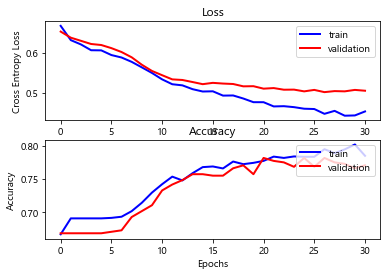

========= Eperiment -  SimpleRNN + fasttext + error analysis  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-441
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1336
           1       0.69      0.53      0.60       604

    accuracy                           0.78      1940
   macro avg       0.75      0.71      0.73      1940
weighted avg       0.77      0.78      0.77      1940

Predicted     0    1
Actual              
0          1193  143
1           282  322


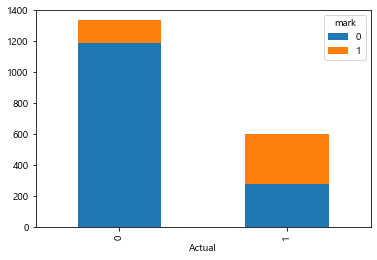

In [28]:
PARAMS = {'epoch': EPOCHS,
          'lr': 0.0001,
          'batch':BATCH_SIZE,
          'stemmed':False,
          'embedding':'fasttext',
          'emb_trainable':False
          }
RNN_model,prediction = train_model(model,X_train,X_test,Y_train,Y_test,"SimpleRNN + fasttext + error analysis")

In [ ]:
save_predictions(X_te,Y_test,prediction,"RNN_error_analysis2")

### Result and logging

In [19]:
def result_map(x):
    if(x==0):
        return "Not Hate"
    if(x==1):
        return "Hate"

def save_predictions(X_test,Y_test,prediction,filename):
    i=0
    arr_index=X_test.index
    Results = pd.DataFrame(columns=["org_index","comment","pred_label","label"])
    for s in X_test:
        print(s)
        Results.at[i,"org_index"] = arr_index[i]
        Results.at[i,"comment"] = s
        Results.at[i,'pred_label'] = prediction[i]
        Results.at[i,'label'] = Y_test[arr_index[i]]
        print("Predicted Label : ",ressult_map(prediction[i])," | Turth Label : ",ressult_map(Y_test[arr_index[i]]))
        i+=1
        print()
    Results.to_csv("Predictions_result/"+filename+".csv",index=False)
    Results.head(n=10)

In [21]:
def train_model(model,train_seq,test_seq,Y_train,Y_test,tag):
  
  #define callbacks
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1,mode='min',restore_best_weights=True)
  checkpoints = ModelCheckpoint(filepath='../trained_models/checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5', monitor="val_loss", mode="min", verbose=1, save_best_only=True)
  callbacks_list = [early_stopping,NeptuneMonitor(),checkpoints]

  #model training
  print("started training")
  hist = model.fit(train_seq, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list,validation_split=0.1, shuffle=False, verbose=2)
  train_loss, train_acc = model.evaluate(train_seq, Y_train,batch_size=BATCH_SIZE, verbose=1)
  print("train loss - ",train_loss," train acc- ",train_acc)
  test_loss, test_acc = model.evaluate(test_seq,Y_test,batch_size=BATCH_SIZE, verbose=1)
  print("test loss - ",test_loss," test acc- ",test_acc)

  # plot loss during training
  #from matplotlib import pyplot
  print('Train acc: %.3f, Test acc: %.3f' % (train_acc, test_acc))
  plt.subplot(211)
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel("Cross Entropy Loss")
  plt.plot(hist.history['loss'],lw=2.0, color='b', label='train')
  plt.plot(hist.history['val_loss'],lw=2.0, color='r', label='validation')
  plt.legend(loc='upper right')
  # plot accuracy during training
  plt.subplot(212)
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(hist.history['acc'],lw=2.0, color='b', label='train')
  plt.plot(hist.history['val_acc'],lw=2.0, color='r', label='validation')
  plt.legend(loc='upper right')
  plt.show()
  #(model.predict(x) > 0.5).astype("int32")
  #np.where(y_pred > threshold, 1,0)
  Y_pred =(model.predict(test_seq) > 0.5).astype("int32")# model.predict_class(test_seq)
  Y_pred = np.squeeze(Y_pred)
  log_result(Y_test,Y_pred,tag)
  neptune.log_metric("train_loss",train_loss)
  neptune.log_metric("train_acc",train_acc)
  neptune.log_metric("test_loss",test_loss)
  neptune.log_metric("test_acc",test_acc)
  #neptune.log_text("RNN model summary",model.summary())
  # neptune.log_image("accuracy_chart",hist.history['accuracy'])
  # neptune.log_image("accuracy_chart",hist.history['val_accuracy'])
  # neptune.log_image("loss_chart",hist.history['loss'])
  # neptune.log_image("loss_chart",hist.history['val_loss'])
  print(classification_report(Y_test,Y_pred))
  #Y_pred = np.squeeze(Y_pred)
  utills.confusion_Matrix(Y_test,Y_pred)
  utills.PlotRocAuc(Y_test,Y_pred,'blue',tag)
  return model,Y_pred

In [22]:
def log_result(Y_test,Y_pred,tag):
    print("========= Eperiment - ",tag," =========")
    neptune.create_experiment(tag,params=PARAMS)
    neptune.append_tag(['DL experiment',tag])
    
    log_class_metrics(Y_test, Y_pred)
    log_confusion_matrix(Y_test, Y_pred)
    log_classification_report(Y_test, Y_pred)

In [33]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

#### Create class

In [ ]:
class RNNClassifier():
    

### Error Analysis

##### LIME (Local INterpretable Model agnostic Explanations)
LIME basically tests what happens to the predictions once the model is provided with certain variations in the input data.


To test this, LIME trains an interpretable model on a new dataset consisting of perturbed samples and the corresponding predictions of the black box model.


This new learned model needs to be a good local approximation (for a certain individual prediction), but doesn’t have to be a good global approximation.

In [84]:
import lime
explainer = lime.LimeTextExplainer(class_names=[0,1])
exp = explainer.explain_instance(X_te, predict_proba)

AttributeError: module 'lime' has no attribute 'LimeTextExplainer'

In [81]:
def predict_proba(arr):
 
  pred=RNN_model.predict(sequence.pad_sequences(token.texts_to_sequences(arr),maxlen=MAX_SEQ_LEN))
  returnable=[]
  for i in pred:
    temp=i[0]
    returnable.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places
  return np.array(returnable)

In [ ]:
exp.show_in_notebook()

In [99]:
import eli5
from eli5.lime import TextExplainer

token = Tokenizer(num_words=LEN_VOCAB)
token.fit_on_texts(X_tr)
te = TextExplainer(random_state=42)
def dl_predict(x):
    return RNN_model.predict(sequence.pad_sequences(token.texts_to_sequences(x), maxlen=MAX_SEQ_LEN))
te.fit(X_te[1119],predict_proba)
te.show_prediction(target_names=[0,1])

In [100]:
te.fit(X_te[5601],predict_proba)
te.show_prediction(target_names=[0,1])

##### SHAP (SHapley Additive exPlanations)

This value is the average marginal contribution of a feature value across all the possible combinations of features

the Shapley value: It is the average of the marginal contributions across all permutations. 

Impact of A = Team Performance with A - Team performance without A



In [53]:
import shap
#session = tf.compat.v1.keras.backend.get_session()
#session = keras.backend.tensorflow_backend.get_session()
distrib_samples = X_train[:100]
explainer = shap.DeepExplainer(RNN_model, distrib_samples)
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
num_explanations = 25
shap_values = explainer.shap_values(X_test[:num_explanations])

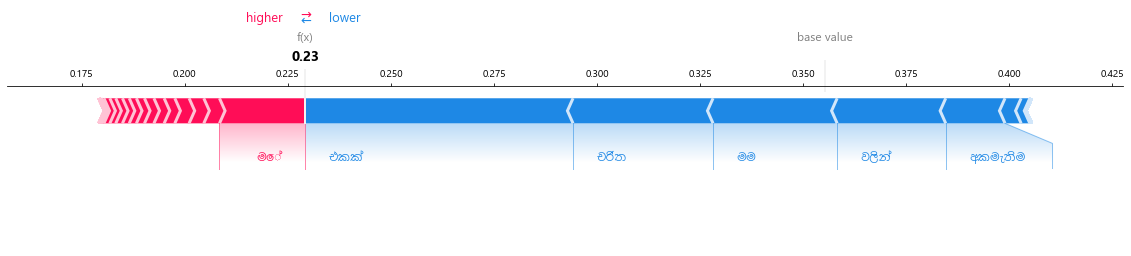

Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.


In [57]:
shap.initjs()
num2word = {}
for w in word_index.keys():
    num2word[word_index[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), X_test[i]))) for i in range(num_explanations)])
shap.force_plot(explainer.expected_value[0], shap_values[0][20], x_test_words[20],matplotlib=True)
#shap.summary_plot(shap_values, feature_names = list(num2word.values()), class_names = [0,1],)
# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.


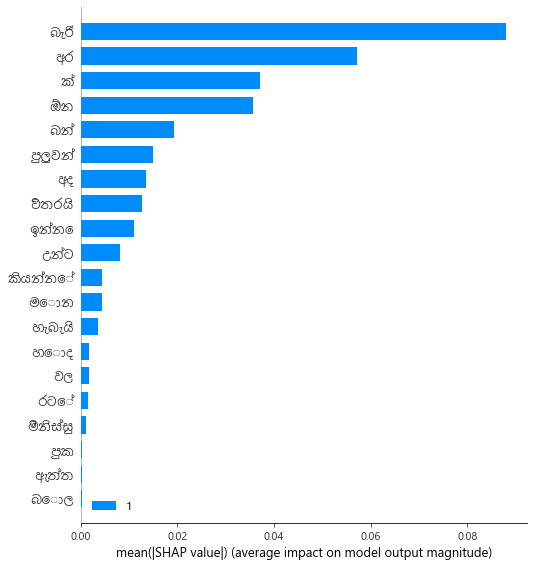

In [52]:
shap.initjs()
shap.summary_plot(shap_values, feature_names = list(num2word.values()), class_names = [0,1])
#mean absolute value of the SHAP values for each feature to get a standard bar plot

In [35]:
# generate 10 predictions
y_pred = RNN_model.predict(X_test[:10])
sample = 8
true_class = list(Y_test[sample]).index(1)
pred_class = list(y_pred[sample]).index(max(y_pred[sample]))
# one hot encoded result
print(f'Predicted vector is {y_pred[sample]} = Class {pred_class} = {num2label[pred_class]}')
# filter padding words
print(f'Input features/words:')
print(x_test_words[sample][np.where(x_test_words[sample] != 'NONE')])
print(f'True class is {true_class} = {num2label[true_class]}')
max_expected = list(explainer.expected_value).index(max(explainer.expected_value))
print(f'Explainer expected value is {explainer.expected_value}, i.e. class {max_expected} is the most common.')

TypeError: 'numpy.int64' object is not iterable

Kernel SHAP is a method that uses a special weighted linear regression to compute the importance of each feature. The computed importance values are Shapley values from game theory and also coefficents from a local linear regression.

In [37]:
kernel_explainer = shap.KernelExplainer(RNN_model.predict, distrib_samples)
kernel_shap_values = kernel_explainer.shap_values(X_test[:num_explanations])

100%|██████████| 10/10 [15:38<00:00, 93.82s/it]


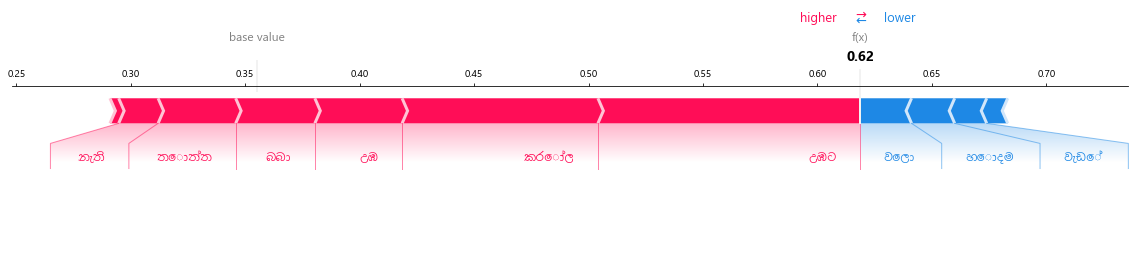

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\util\connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Users\Kavishka\anaconda3\lib\socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "C:\Use

In [51]:
# plot the explanation of a given prediction
class_num = 0
input_num = 7
shap.force_plot(kernel_explainer.expected_value[class_num], kernel_shap_values[class_num][input_num], x_test_words[input_num],matplotlib=True)


In [45]:
# explanations of the output for the given class 
# y center value is base rate for the given background data
shap.force_plot(kernel_explainer.expected_value[class_num], kernel_shap_values[class_num], x_test_words[:10])